In [1]:
import sys
import subprocess
import cdsapi
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib import pyplot as plt

import errno
from dask.diagnostics import ProgressBar, progress
import scipy
import netCDF4
from dask.distributed import wait, progress

In [2]:
from dask.distributed import Client

#client = Client(n_workers=56,dashboard_address=':8788', threads_per_worker=2, memory_limit='4GB')
client = Client('tcp://127.0.0.1:55492')
client

Client Scheduler: tcp://127.0.0.1:55492 Dashboard: http://127.0.0.1:58098/status,Cluster Workers: 8 Cores: 48 Memory: 270.36 GB


In [4]:
# Fix the hourly precip and solar radiation
def special_diff(x):
    d = np.diff(np.append(0,x))
    return np.array(d)


def special_func(data):
    return xr.apply_ufunc(special_diff, data, 
                          input_core_dims=[["time"]],
                          output_core_dims=[["time"]],
                          dask = 'parallelized', 
                          vectorize = True,
                          output_dtypes=[np.float32])

In [23]:
mychunk = {'latitude':25,'longitude':25,'time': -1}
basedir = '/mnt/DataDrive2/data/mjolly/era5-land'
def RunPrcpSradReform(zone):
    yrs = range(2015,2021)
    mons = range(1,13)
    for y in yrs:
        for m in mons:
            print(y,m)
            print("Reading hourly precip for %s for domain %s" % (y,zone))
            ifile = '%s/era5-land-%s-total_precipitation-%s-%02d.nc' % (basedir,zone,y,m)
            zone_prcp= xr.open_mfdataset(ifile,chunks=mychunk,parallel=True,engine='netcdf4')
            temp = zone_prcp.time
            tempsave = zone_prcp.time
            temp = xr.where((temp.dt.hour == 0), temp - np.timedelta64(1,'s'), temp)
            zone_prcp['time'] = temp
            zone_prcp = zone_prcp.tp.resample(time='1D').apply(special_func)
            zone_prcp['time'] = tempsave
            ofile = '%s/era5-land-%s-total_hourly_precipitation-%s-%02d.nc' % (basedir,zone,y,m)
            zone_prcp.to_netcdf(ofile,format="NETCDF4")

%time RunPrcpSradReform("SAR") 

2015 1
Reading hourly precip for 2015 for domain SAR
2015 2
Reading hourly precip for 2015 for domain SAR
2015 3
Reading hourly precip for 2015 for domain SAR
2015 4
Reading hourly precip for 2015 for domain SAR
2015 5
Reading hourly precip for 2015 for domain SAR
2015 6
Reading hourly precip for 2015 for domain SAR
2015 7
Reading hourly precip for 2015 for domain SAR
2015 8
Reading hourly precip for 2015 for domain SAR
2015 9
Reading hourly precip for 2015 for domain SAR
2015 10
Reading hourly precip for 2015 for domain SAR
2015 11
Reading hourly precip for 2015 for domain SAR
2015 12
Reading hourly precip for 2015 for domain SAR
2016 1
Reading hourly precip for 2016 for domain SAR
2016 2
Reading hourly precip for 2016 for domain SAR
2016 3
Reading hourly precip for 2016 for domain SAR
2016 4
Reading hourly precip for 2016 for domain SAR
2016 5
Reading hourly precip for 2016 for domain SAR
2016 6
Reading hourly precip for 2016 for domain SAR
2016 7
Reading hourly precip for 2016 for d

In [17]:
basedir = '/mnt/DataDrive2/data/mjolly/era5-land'
y = 2015
m = 2
zone = "SAR"
ofile = '%s/era5-land-%s-total_hourly_precipitation-%s-%02d.nc' % (basedir,zone,y,m)
df = xr.open_dataset(ofile,engine='netcdf4')

ifile = '%s/era5-land-%s-total_precipitation-%s-%02d.nc' % (basedir,zone,y,m)
df2 = xr.open_dataset(ifile,engine='netcdf4')

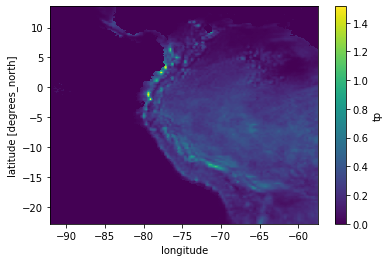

In [18]:
df.tp.sum("time").plot()

In [19]:
zone_prcp_pt = df.sel(latitude=-11.58257164274016,longitude=-70.61278378627453,method='nearest')
zone_prcp_pt2 = df2.sel(latitude=-11.58257164274016,longitude=-70.61278378627453,method='nearest')

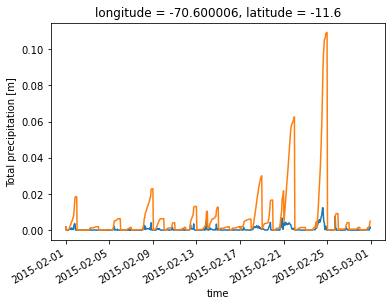

In [21]:
zone_prcp_pt.tp.plot()
zone_prcp_pt2.tp.plot()